In [56]:
%reload_ext autoreload
%autoreload 2

import pandas as pd

# the name and location of the article records for the IM journal (in CSV format)
records_file = '../data/main-review-article-records.csv'

columns = ['article_title', 'issue_pub_year', 'publisher', 'article_type']
# load the csv data into a data frame
df = pd.read_csv(records_file, usecols=columns)
# show the first and last records of the dataset to demonstrate what the records look like
df.head(5)

,article_title,issue_pub_year,publisher,article_type
0,The importance of emigration for the solution ...,1951,Staatsdrukkerij,main
1,European emigration overseas past and future,1951,Staatsdrukkerij,main
2,Some aspects of migration problems in the Neth...,1952,Staatsdrukkerij,main
3,Some quantitative aspects of future population...,1952,Staatsdrukkerij,main
4,"The refugees as a burden, a stimulus, and a ch...",1951,Staatsdrukkerij,main


In [57]:
def map_dataset(publisher, article_type):
    # all REMP and IM (published by Wiley) articles are bunlded in a single dataset
    if publisher == 'Staatsdrukkerij' or publisher == 'Wiley':
        return 'REMP_IM'
    # The IMR articles are separated in review articles and research articles
    return 'IMR_research' if article_type == 'main' else 'IMR_review'

df['dataset'] = df.apply(lambda x: map_dataset(x['publisher'], x['article_type']), axis=1)
df.dataset.value_counts()

IMR_review      1842
IMR_research    1539
REMP_IM          903
Name: dataset, dtype: int64

In [58]:
# adding a column per article with the publication decade
df['issue_decade'] = df.issue_pub_year.apply(lambda x: int(x/10) * 10 if not pd.isnull(x) else x)

df.issue_decade.value_counts()

1990    1490
1980    1236
1970    1052
1960     404
1950     102
Name: issue_decade, dtype: int64

In [59]:
import scripts.content_analysis as ca

# create a normalised version of the article title
# - remove footnote symbols, stopwords, punctuation and quote characters
# - standardise acronyms
# - remove 'Book Review: ' prefix from review article titles
df['normalised_title'] = df.article_title.apply(ca.normalise_title)
df.normalised_title

0       the importance of emigration for the solution ...
1            european emigration overseas past and future
2       some aspect of migration problem in the nether...
3       some quantitative aspect of future population ...
4       the refugee as a burden a stimulus and a chall...
                              ...                        
4279                                chapter four go north
4280               chapter five the new york labor market
4281                   chapter six the settlement process
4282                             chapter seven conclusion
4283                                         bibliography
Name: normalised_title, Length: 4284, dtype: object

In [60]:
from collections import defaultdict
bigram_freq = ca.get_bigram_freq(list(df.normalised_title), remove_stop=True)

endings = ['migration', 'immigration', 'emigration']
ending_bigrams = defaultdict(list)

for bigram, freq in bigram_freq.most_common(10000):
    for ending in endings:
        if bigram.endswith(f' {ending}'):
            ending_bigrams[ending].append((bigram, freq))
            
for ending in endings:
    for bigram, freq in ending_bigrams[ending]:
        print(bigram, freq)

international migration 115
return migration 40
labor migration 33
internal migration 32
labour migration 22
european migration 9
south-north migration 8
mexican migration 7
east-west migration 6
undocumented migration 6
overseas migration 5
human migration 5
rural-urban migration 5
urban migration 5
indian migration 5
force migration 4
italian migration 4
selective migration 3
post-war migration 3
economic migration 3
new migration 3
mass migration 3
family migration 3
chain migration 3
irregular migration 3
illegal migration 3
philippine migration 3
woman migration 3
recent migration 3
modern migration 2
external migration 2
plan migration 2
community migration 2
chinese migration 2
manpower migration 2
group migration 2
migration migration 2
quiet migration 2
net migration 2
circular migration 2
north migration 2
change migration 2
rural migration 2
female migration 2
rican migration 2
population migration 2
black migration 2
canadian migration 2
nonreturn migration 2
us migration 2

In [61]:
from collections import Counter, defaultdict

from scripts.countries import CountryLookup

lookup = CountryLookup()

ending_freq = defaultdict(Counter)

for ending in endings:
    for bigram, freq in ending_bigrams[ending]:
        countries, continents = lookup.extract_countries_continents(bigram, include_nationalities=True)
        #print(bigram, freq, countries, continents)
        ending_freq[ending].update(countries + continents)
        
for ending in ending_freq:
    for region, freq in ending_freq[ending].most_common(10):
        print(ending, region, freq)

migration Europe 10
migration Asia 9
migration North America 5
migration Philippines 2
migration Australia 2
migration Oceania 2
migration South America 2
migration Africa 2
migration Mexico 1
migration India 1
immigration Europe 9
immigration Asia 8
immigration North America 5
immigration Africa 3
immigration Canada 2
immigration Australia 2
immigration Oceania 2
immigration South America 2
immigration Mexico 2
immigration Germany 2
emigration Europe 13
emigration North America 4
emigration Asia 3
emigration South America 2
emigration Italy 1
emigration Spain 1
emigration Netherlands 1
emigration Ireland 1
emigration United Kingdom 1
emigration Malta 1


In [64]:
topic_lists = """
- cause_effect: cause, causal, determinant, factor, influen, setting, effect, affect, impact, consequence, implication
- process: process, dynamic, rate, development, pattern, change, changing, interact, relation, evolution, transform, interpretation, participat
- decision making: policy, policies, politic, decision, management, managing, govern, promotion, planned, recruitment, law, act, implement, amend, guidelines, reform, program, enforcement, legislation, legislative, control, refine, revis, border, international, national, protection, coordination, rationale, administrat, examinat
- labour: labour, labor, worker, work, employment, occupation,
- skill: low-skill, skilled, skill, high-level, professional, intellectual, scientist, brain drain, vocational, vocational training
- legal: illegal, legal, undocumented, unwanted, undesirable, citizenship, right
- forced: involuntary, forced, refuge, refugee, necessity, war, conflict, asylum
- immigration: immigrant, immigrate, immigration
- emigration: emigrant, emigrate, emigration, overseas destination, voluntary return
- migration: migratory, migrant, migración, migrantes, migratoria, migraciones, migraci, arbeitsmigranten, migratori, migrazioni, migratoire, migrações
- group: family, household, community, group
- identity: identity, nationality, nationalism, xenophob, ethnic, race, ideolog, naturali, assimilation, integration, adaptation , absorption
"""

extra = """
- outcome: failure, disenchantment, success, advantage, disadvantage, positive, negative
- business: business, entrep, production, market, industr
- education: education, school, learn
- health: health, medic, disease, epidem
- gender: male, female, gender, women
"""

def make_topics(topic_lists):
    topic_lists = [topic_list[2:] for topic_list in topic_lists.split('\n') if topic_list != '']
    topic_words = {tl.split(': ')[0]: tl.split(': ')[1].split(', ') for tl in topic_lists}
    return topic_words

discipline_lists = """
- psychology: psycholog
- economy: economy, economic, trade
- statistics: statist
- sociology: sociology, social, socio-economic, anthropology, culture
- demography: demography, demographic
"""
discipline_words = make_topics(discipline_lists)

topic_words = make_topics(topic_lists)
topic_words

{'cause_effect': ['cause',
  'causal',
  'determinant',
  'factor',
  'influen',
  'setting',
  'effect',
  'affect',
  'impact',
  'consequence',
  'implication'],
 'process': ['process',
  'dynamic',
  'rate',
  'development',
  'pattern',
  'change',
  'changing',
  'interact',
  'relation',
  'evolution',
  'transform',
  'interpretation',
  'participat'],
 'decision making': ['policy',
  'policies',
  'politic',
  'decision',
  'management',
  'managing',
  'govern',
  'promotion',
  'planned',
  'recruitment',
  'law',
  'act',
  'implement',
  'amend',
  'guidelines',
  'reform',
  'program',
  'enforcement',
  'legislation',
  'legislative',
  'control',
  'refine',
  'revis',
  'border',
  'international',
  'national',
  'protection',
  'coordination',
  'rationale',
  'administrat',
  'examinat'],
 'labour': ['labour', 'labor', 'worker', 'work', 'employment', 'occupation,'],
 'skill': ['low-skill',
  'skilled',
  'skill',
  'high-level',
  'professional',
  'intellectual',
 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


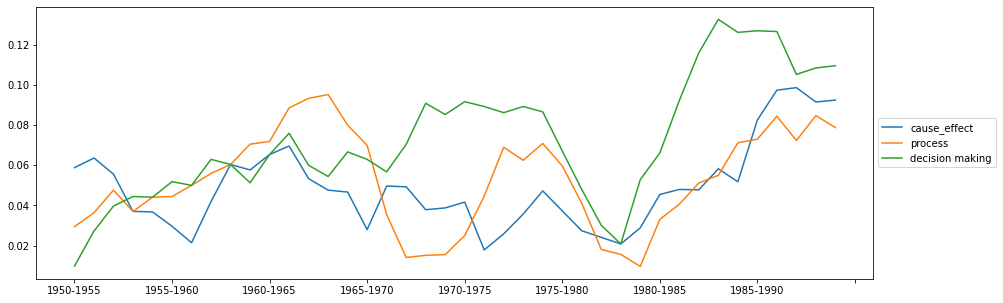

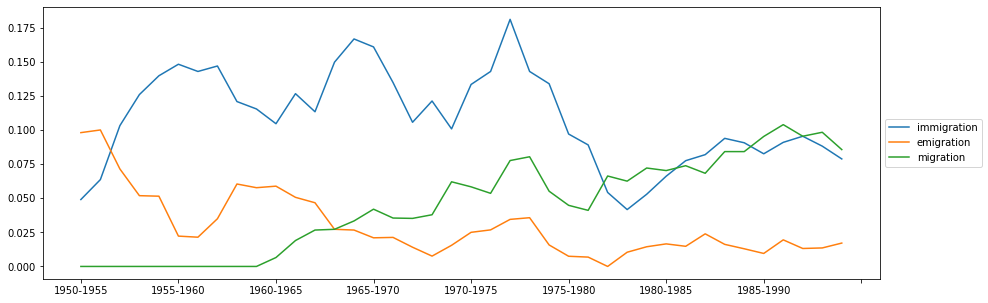

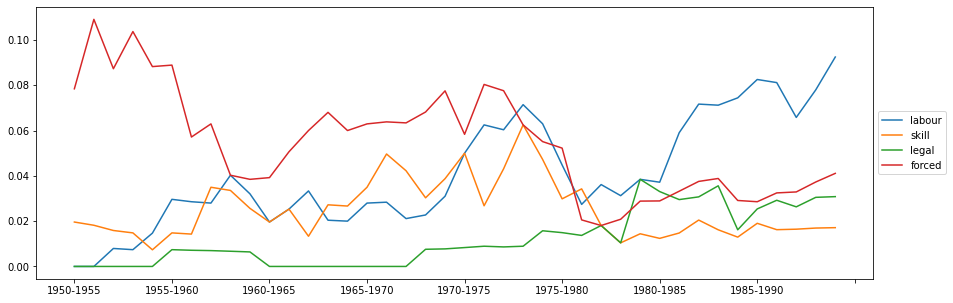

In [65]:
import re

def has_topic(title, topic_words):
    for topic_word in topic_words:
        if re.search(r'\b' + topic_word, title.lower()):
        #if topic_word in title.lower():
            return 1
    return 0

def select_df_by_topic(df, topic_words, topic):
    return df[df.article_title.apply(lambda x: has_topic(x, topic_words[topic])) == 1]

def slide_decade(df, window_size: int = 10):
    num_pubs = []
    periods = []
    for start_year in range(1950, 1990):
        end_year = start_year + window_size
        periods.append(f"{start_year}-{end_year}")
        num_pubs.append(len(df[(df.issue_pub_year >= start_year) & (df.issue_pub_year < end_year)]))
    return num_pubs


def get_topics_df(df, topic_words, window_size: int = 10):
    data = {}
    for topic in topic_words:
        topic_df = select_df_by_topic(df, topic_words, topic)
        data[topic] = slide_decade(topic_df, window_size)

    periods = []
    for start_year in range(1950, 1990):
        end_year = start_year + window_size
        periods.append(f"{start_year}-{end_year}")

    data['total'] = slide_decade(df)
    
    topics_df = pd.DataFrame(data, index=periods)
    
    for topic in topics_df.columns:
        topics_df[topic] = topics_df[topic] / topics_df['total']
        
    return topics_df

# Set the sliding window size
window_size = 5


selected_topic_words = {}
selected_topics = ['cause_effect', 'process', 'decision making']
for topic in selected_topics:
    selected_topic_words[topic] = topic_words[topic]

df_remp_im = df[df.dataset == 'REMP_IM']
topics_df = get_topics_df(df_remp_im, selected_topic_words, window_size)
topics_df.drop('total', axis=1).plot(figsize=(15,5)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

selected_topic_words = {}
selected_topics = ['immigration', 'emigration', 'migration']
for topic in selected_topics:
    selected_topic_words[topic] = topic_words[topic]

topics_df = get_topics_df(df_remp_im, selected_topic_words, window_size)
topics_df.drop('total', axis=1).plot(figsize=(15,5)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

selected_topic_words = {}
selected_topics = ['labour', 'skill', 'legal', 'forced']
for topic in selected_topics:
    selected_topic_words[topic] = topic_words[topic]

topics_df = get_topics_df(df_remp_im, selected_topic_words, window_size)
topics_df.drop('total', axis=1).plot(figsize=(15,5)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


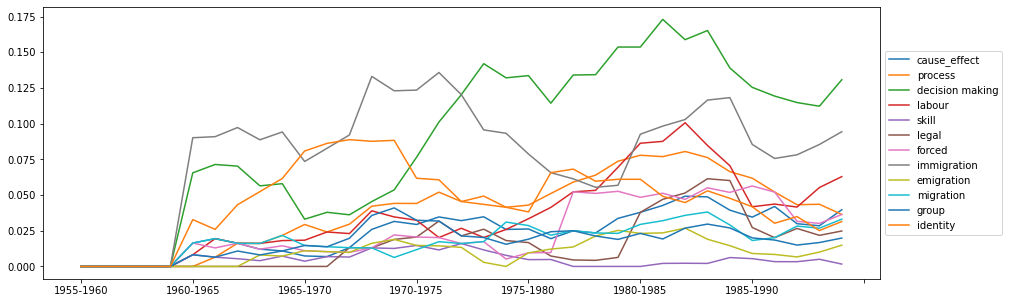

In [67]:
df_imr_research = df[df.dataset == 'IMR_research']
topics_df = get_topics_df(df_imr_research, topic_words, window_size)


topics_df.drop('total', axis=1).plot(figsize=(15,5)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


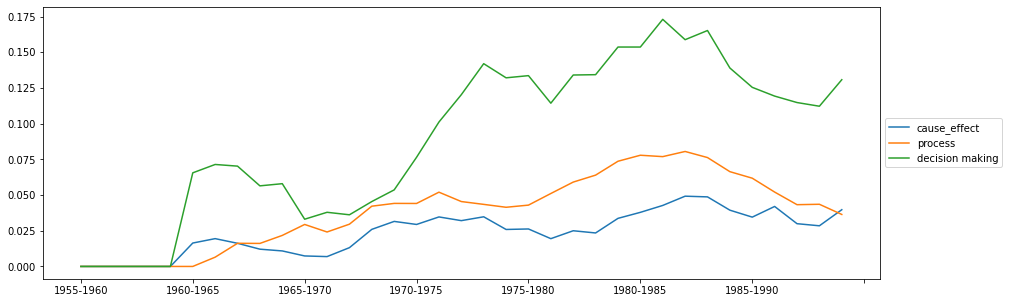

In [68]:
selected_topic_words = {}
selected_topics = ['cause_effect', 'process', 'decision making']
for topic in selected_topics:
    selected_topic_words[topic] = topic_words[topic]

topics_df = get_topics_df(df_imr_research, selected_topic_words, window_size)
topics_df.drop('total', axis=1).plot(figsize=(15,5)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


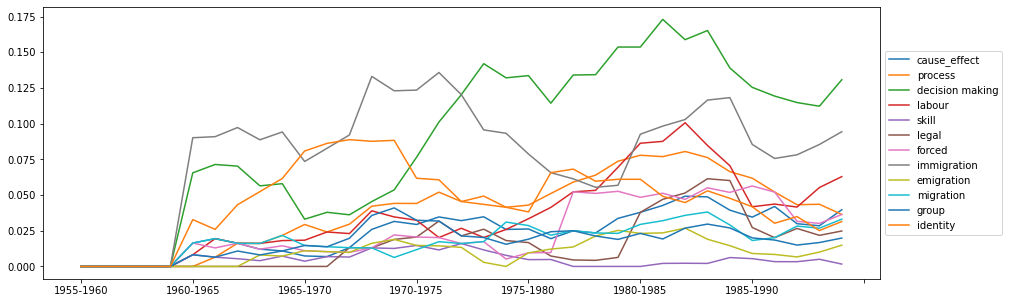

In [69]:
topics_df = get_topics_df(df_imr_research, topic_words, window_size)


topics_df.drop('total', axis=1).plot(figsize=(15,5)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


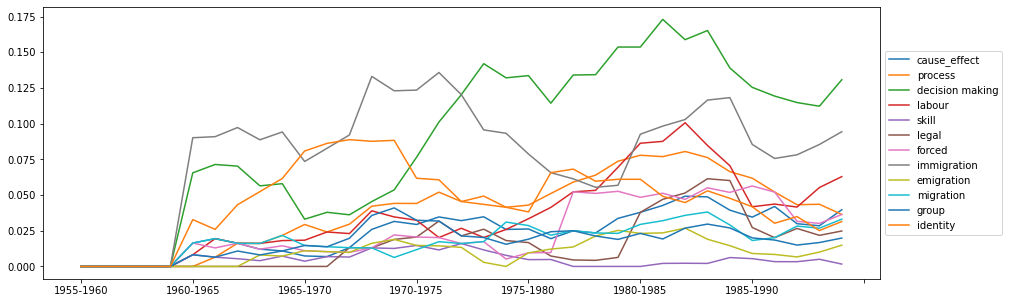

In [70]:
topics_df = get_topics_df(df_imr_research, topic_words, window_size)


topics_df.drop('total', axis=1).plot(figsize=(15,5)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

### Observations

- The number of publications increases over time. For many topics, the relative proportion of articles that cover a specific topic drops. This may be a signal that the diversity of topics increases, or that terminology diversifies.



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


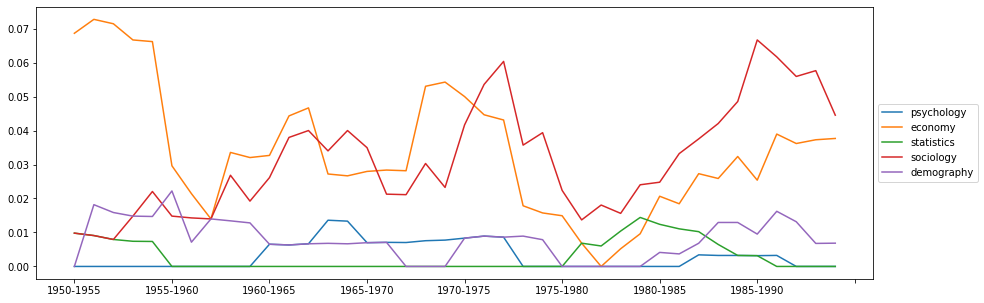

In [71]:
topics_df = get_topics_df(df_remp_im, discipline_words, window_size)
topics_df.drop('total', axis=1).plot(figsize=(15,5)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


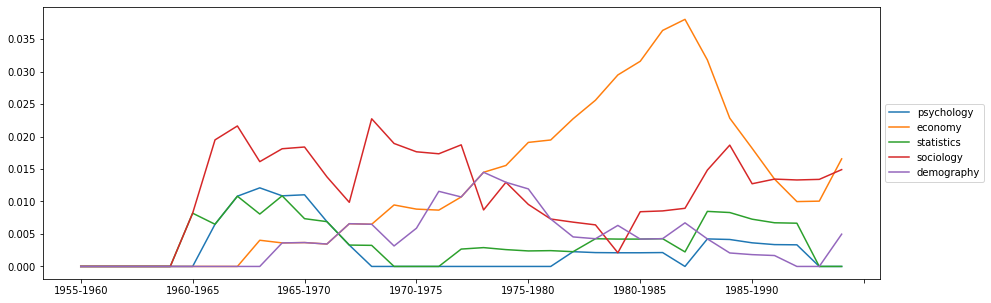

In [72]:
topics_df = get_topics_df(df_imr_research, discipline_words, window_size)
topics_df.drop('total', axis=1).plot(figsize=(15,5)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

In [ ]:
classified_terms = {}
classified_terms[‘migration’] = {
            ‘migration’:[‘migratory’, ‘migrant’, ‘migrations’,‘migrants’, ‘migración’, ‘migrantes’,
                        ‘migratoria’, ‘migraciones’,‘migracion’, ‘migraciín’,‘migrante’, ‘migracidn’,‘migrationsverhalten’,
                       ‘arbeitsmigranten’, ‘migratori’, ‘migrazioni’,‘migratoire’, ‘migrações’, ],
           ‘integration’:[‘assimilation’,‘integration’,‘adaptation’,‘absorption’, ‘naturalization’,‘legalization’,],
           ‘emigration’:[‘emigrants’, ‘emigrant’, ‘emigracion’, ‘emigración’,‘emigrazione’, ‘emigrati’,‘emigração’,
                        ‘emigratión’,  ‘emigranti’, ‘lémigration’, ‘émigration’,‘emigrate’,],
           ‘immigration’:[‘immigrants’,‘immigrant’,‘inmigrant’, ‘immigración’, ‘immigrazione’, ‘immigrantes’,
                       ‘inmigrantes’, ‘inmigration’, ‘iimmigrants’,‘inmigracion’,‘inmigración’,‘inmigrante’, ‘immigrate’,
                          ‘immigrati’,],
           ‘remigration’:[‘remigration’, ‘transmigration’, ‘transmigrant’,‘reemigracja’,‘euromigration’,‘postmigration’,‘repatriation’]}
classified_terms[‘disciplines’] = {
                    ‘sociology’:[‘sociology’, ‘sociological’, ‘sociologique’, ‘sociologica’,  ‘sociologia’, ‘sociolinguistics’],
                    ‘statistics’:[‘statistics’,‘statistical’],
                    ‘methods’:[‘methodological’,‘methodologique’, ‘metodologica’,‘typology’,‘topics’,‘characteristics’],
                    ‘psychology’:[‘psychological’,‘psychology’],
                    ‘politics’:[‘politics’,‘political’],
                    ‘anthropology’:[‘ethnological’, ‘anthropology’,‘anthropological’,],
                    ‘other’:[‘ecology’,‘ecological’,‘ideology’,‘ideological’,‘mythology’,‘demythologizing’,
                            ‘technology’, ‘epidemiology’, ‘tecnologia’, ‘technological’,‘biological’,‘cosmology’, ‘chronology’, ‘ideologies’,
                            ‘economics’,‘ethnics’,‘electronics’,‘ethics’]}

In [26]:
temp_df = df[df.normalised_title.str.contains('latin')][['dataset', 'issue_decade']]
s = temp_df.groupby(['dataset', 'issue_decade']).size()

s.unstack('dataset')


dataset,IMR_research,IMR_review,REMP_IM
issue_decade,,,
1960,NaN,4.0,10.0
1970,7.0,8.0,1.0
1980,2.0,11.0,2.0
1990,3.0,10.0,2.0
